In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
import pickle
import os, sys
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec
from metpy import plots as metpy_plots
from matplotlib.colors import ListedColormap, BoundaryNorm


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))
log_folder = '/user/work/uz22147/logs/cgan/38fba564f1c9852b/n1000_201806-201905_e50'

from dsrnngan.plots import plot_precip
from dsrnngan.data import denormalise
from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh
from dsrnngan.plots import plot_precip


In [4]:
eval_df = pd.read_csv(os.path.join(log_folder, 'eval_validation.csv'))
eval_df.head()

,N,op,CRPS_no_pooling,CRPS_max_4,CRPS_max_16,CRPS_avg_4,CRPS_avg_16,mae,rmse,emmse,emmse_fcst,ralsd,corr,corr_ensemble,corr_fcst
0,160000,0.077346,0.121360,0.121360,0.121360,0.121360,0.121360,0.199353,0.870995,0.572712,0.570935,3.551033,0.071014,0.044637,0.021691
1,N,op,CRPS_no_pooling,CRPS_max_4,CRPS_max_16,CRPS_avg_4,CRPS_avg_16,mae,rmse,emmse,emmse_fcst,ralsd,corr,corr_ensemble,corr_fcst
2,160000,0.057789,0.051085,0.051085,0.051085,0.051085,0.051085,0.089386,0.643976,0.380141,0.376571,4.135722,0.110858,0.034460,0.029137
3,N,op,CRPS_no_pooling,CRPS_max_4,CRPS_max_16,CRPS_avg_4,CRPS_avg_16,mae,rmse,emmse,emmse_fcst,ralsd,corr,corr_ensemble,corr_fcst
4,160000,0.048508,0.098110,0.098110,0.098110,0.098110,0.098110,0.202153,1.158686,0.717556,0.724488,5.040466,0.069432,0.100051,0.079051


In [5]:
with np.load(os.path.join(log_folder, 'ranks-160000.npz')) as ranks_data:
    ranks_dict = dict(ranks_data.items())

with open(os.path.join(log_folder, 'other_metrics-160000.pkl'), 'rb') as ifh:
    other_metrics = pickle.load(ifh)

with open(os.path.join(log_folder, 'arrays-160000.pkl'), 'rb') as ifh:
    arrays = pickle.load(ifh)

In [21]:
truth_array = arrays['truth']
samples_gen_array = arrays['samples_gen']
fcst_array = arrays['fcst_array']
ensmean_array = np.mean(arrays['samples_gen'], axis=-1)
dates = arrays['dates']
hours = arrays['hours']

(n_samples, width, height, ensemble_size) = samples_gen_array.shape

In [8]:
## This is needed until code is fixed

for n in range(fcst_array.shape[0]):
    fcst_array[n,:,:] = denormalise(fcst_array[n,:,:])

100%|██████████| 5/5 [00:00<00:00, 10.72it/s]


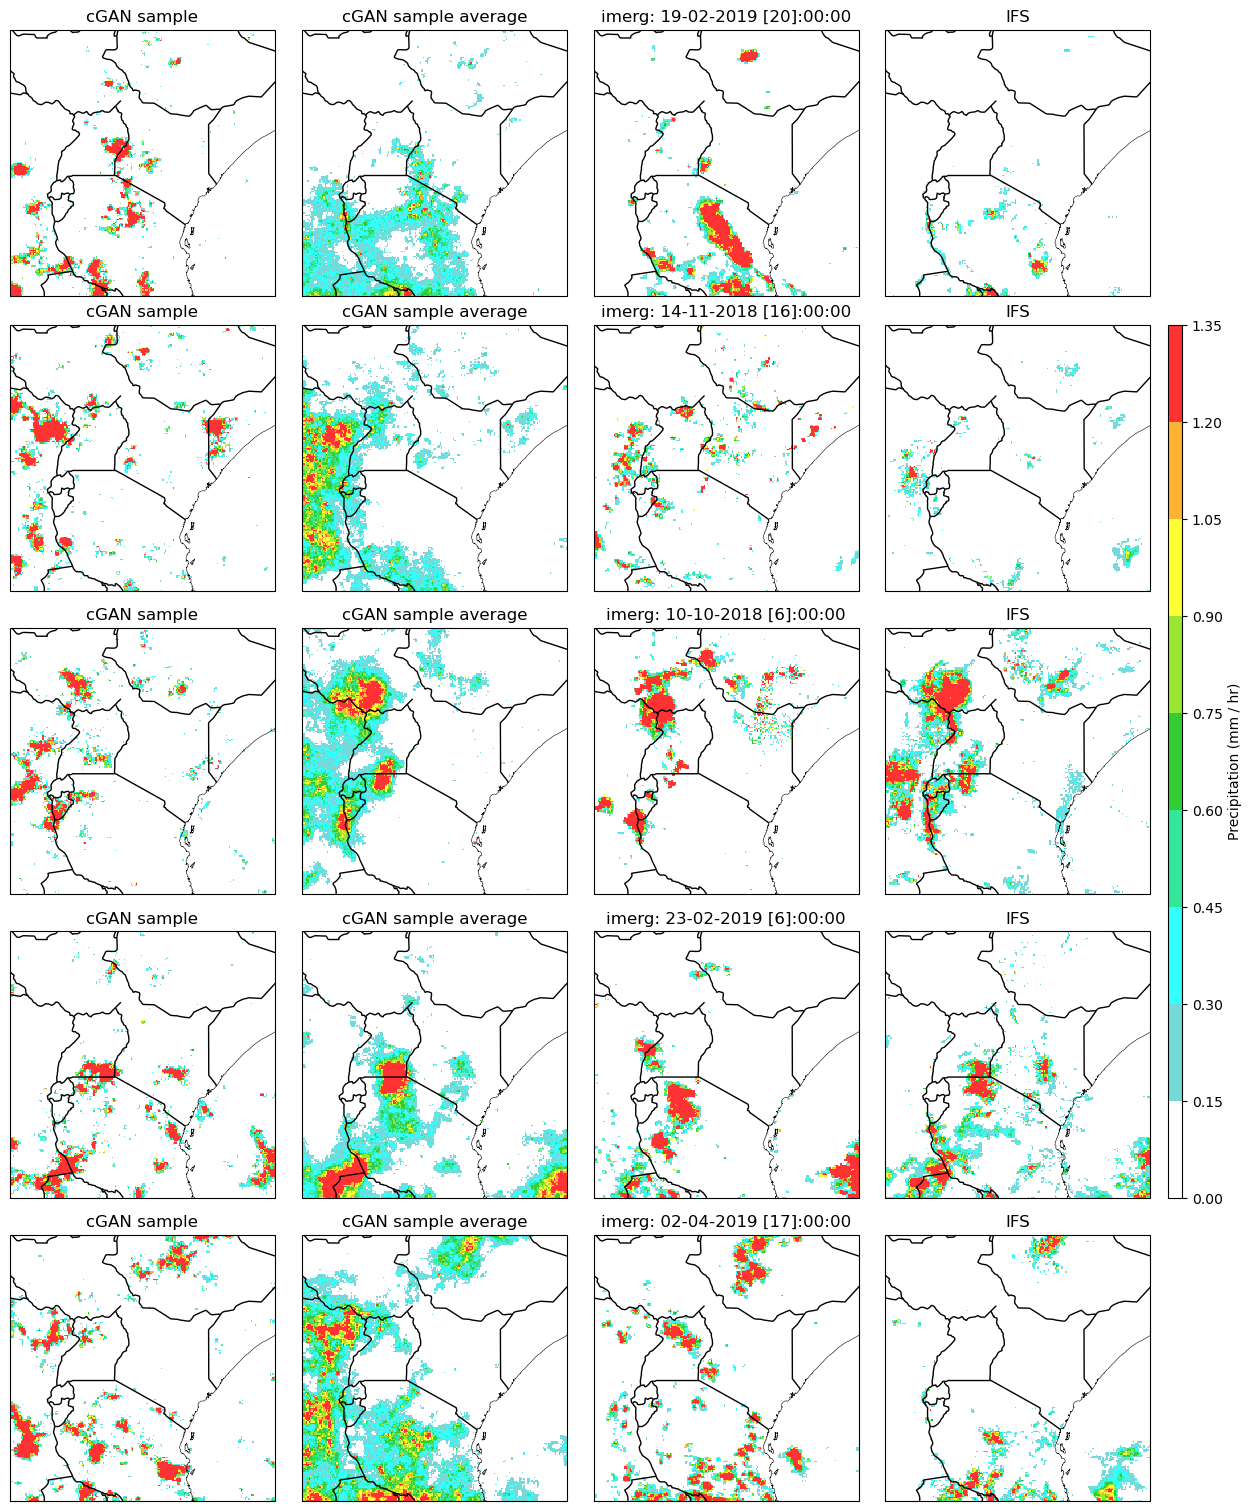

In [9]:


tp_index = data.all_ifs_fields.index('tp')

# plot configurations

spacing = 10
units = "Rain rate [mm h$^{-1}$]"
precip_levels=np.arange(0, 1.5, 0.15)
num_samples = 5
num_rows = num_samples
num_cols = 5

# , figsize = (num_rows*4, num_cols*4)),
# gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=2)
rows = [[f'cgan_sample_{n}', f'cgan_mean_{n}', f'imerg_{n}', f'ifs_{n}', 'cbar'] for n in range(num_rows)]

fig = plt.figure(constrained_layout=True, figsize=(2.5*num_cols, 3*num_rows))
gs = gridspec.GridSpec(num_rows, num_cols, figure=fig, width_ratios=[1]*(num_cols - 1) + [0.05],
                       wspace=0.01)                      
for n in tqdm(range(num_samples)):

    img_gens = samples_gen_array[n, :,:,:]
    truth = truth_array[n,:,:]
    fcst = fcst_array[n,:,:]
    date = dates[n]
    hour = hours[n]
    avg_img_gens = img_gens.mean(axis=-1)
    date_str = date[0].strftime('%d-%m-%Y') + f' {hour}:00:00'
    
    # cGAN
    data_lookup = {'cgan_sample': {'data': img_gens[:,:,0], 'title': 'cGAN sample'},
                   'cgan_mean': {'data': avg_img_gens, 'title': f'cGAN sample average'},
                   'imerg' : {'title': f"imerg: {date_str}", 'data': truth},
                   'ifs': {'data': fcst, 'title': 'IFS'}
                   }
    for col, (k, val) in enumerate(data_lookup.items()):
   
        ax = fig.add_subplot(gs[n, col], projection = ccrs.PlateCarree())
        im = plot_precip(np_array=val['data'], ax=ax, levels=precip_levels)
        ax.set_title(val['title'])
        
precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(precip_levels)-1], 'precipitation')
precip_norm = BoundaryNorm(precip_levels, precip_cmap.N)
cbar_ax = fig.add_subplot(gs[1:-1 ,-1])
# cb = mpl.colorbar.Colorbar(axd['cbar'], cmap=precip_cmap, norm=precip_norm)
# cbar_ax = fig.add_axes([0.95, 0.0, 0.02, 0.95])
cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', shrink = 0.2, aspect=20)

# cb.ax.set_yticks(precip_levels)
# cb.ax.set_yticklabels(precip_levels)
# cb.ax.tick_params(axis='both', which='major')
cb.ax.set_ylabel("Precipitation (mm / hr)")
plt.savefig('cGAN_samples_IFS.png', dpi=fig.dpi)

In [14]:
quantiles = other_metrics['quantiles']
rapsd_dict = {k: v for k, v in other_metrics.items() if k.startswith('rapsd')}
bias_dict = {k: v for k, v in other_metrics.items() if k.startswith('bias')}
crps_dict = {k: v for k, v in other_metrics.items() if k.startswith('CRPS')}

In [15]:
from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE

special_areas = {'lake_victoria': {'lat_range': [-3,1], 'lon_range': [31, 35]},
                 'nairobi': {'lat_range': [-1.5,-1], 'lon_range': [36.5, 37]},
                 'mombasa (coastal)': {'lat_range': [-4.1,-3.9], 'lon_range': [39.5, 39.8]},
                 'addis ababa': {'lat_range': [8.8, 9.1], 'lon_range': [38.5, 38.9]},
                 'bale_mountains': {'lat_range': [6.6, 7.0], 'lon_range': [39.3, 40.2]}}

lat_range = [np.round(item, 1) for item in DEFAULT_LATITUDE_RANGE]
lon_range = [np.round(item, 1) for item in DEFAULT_LONGITUDE_RANGE]

for k, v in special_areas.items():
    special_areas[k]['lat_index_range'] = [lat_range.index(v['lat_range'][0]), lat_range.index(v['lat_range'][1])]
    special_areas[k]['lon_index_range'] = [lon_range.index(v['lon_range'][0]), lon_range.index(v['lon_range'][1])]

## Rank histogram

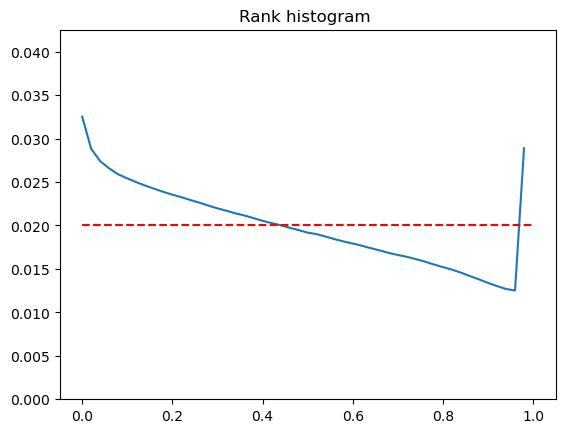

In [16]:
fig, ax = plt.subplots(1,1)
(h, _) = np.histogram(ranks_dict['ranks'], bins=50)
h = h / h.sum()
ax.plot(h)
ax.hlines(1/50, 0, 50, linestyles='dashed', colors=['r'])
ax.set_xticks(np.arange(0, 51, 10))
ax.set_xticklabels(np.round(np.arange(0, 1.2, 0.2), 1))
ax.set_ylim([0, max(h)+0.01])
ax.set_title('Rank histogram ')
plt.savefig('cgan_metrics/rank_hist.png')


# RAPSD

In [24]:
from dsrnngan.rapsd import rapsd

rapsd_truth = []
rapsd_pred = []
rapsd_fcst = []   
for n in tqdm(range(n_samples)):
        fft_freq_pred = rapsd(truth_array[n,:,:], fft_method=np.fft)
        rapsd_truth.append(fft_freq_pred)
        
        fft_freq_pred = rapsd(samples_gen_array[n,:,:,0], fft_method=np.fft)
        rapsd_pred.append(fft_freq_pred)

        fft_freq_fcst = rapsd(fcst_array[n, :, :], fft_method=np.fft)
        rapsd_fcst.append(fft_freq_fcst)

rapsd_truth = np.mean(np.stack(rapsd_truth, axis=-1), axis=-1)
rapsd_pred = np.mean(np.stack(rapsd_pred, axis=-1), axis=-1)
rapsd_fcst = np.mean(np.stack(rapsd_fcst, axis=-1), axis=-1)

100%|██████████| 1000/1000 [00:19<00:00, 50.82it/s]


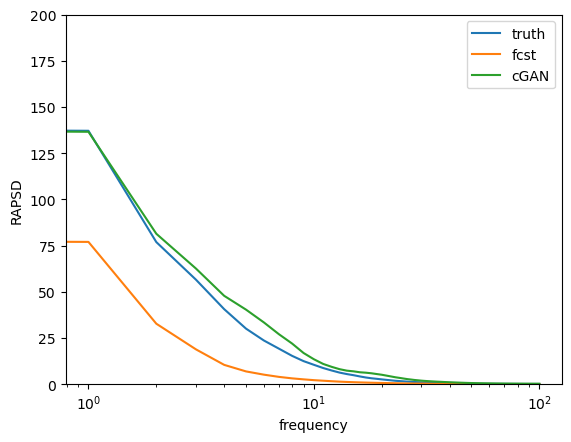

In [39]:
fig, ax = plt.subplots(1,1)

ax.plot(rapsd_truth, label='truth')
ax.plot(rapsd_fcst, label='fcst')
ax.plot(rapsd_pred, label='cGAN') # Single member of ensemble
plt.xscale('log')
ax.set_ylim([0, 200])
ax.set_ylabel('RAPSD')
ax.set_xlabel('frequency')
ax.legend()
plt.savefig('cgan_metrics/rapds.png')

## Quantiles

In [29]:
quantile_boundaries = np.arange(0, 1, 1/20)
truth_quantiles = np.quantile(truth_array, quantile_boundaries)
sample_quantiles = np.quantile(samples_gen_array[:,:,:, 0], quantile_boundaries)
fcst_quantiles = np.quantile(fcst_array, quantile_boundaries)

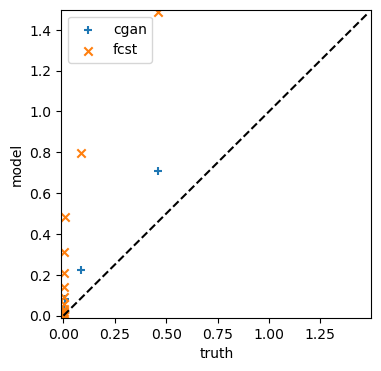

In [35]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

max_val = max(max(truth_quantiles), max(sample_quantiles), max(fcst_quantiles))

ax.scatter(truth_quantiles, sample_quantiles, marker='+', label='cgan')
ax.scatter(truth_quantiles, fcst_quantiles, marker='x', label='fcst')
ax.plot(np.arange(0,max_val, 0.01), np.arange(0,max_val, 0.01), 'k--')
ax.set_xlabel('truth')
ax.set_ylabel('model')
ax.set_xlim([-0.01, max_val + 0.01])
ax.set_ylim([-0.01, max_val + 0.01])
ax.legend()
plt.savefig('cgan_metrics/quantiles_total.png')

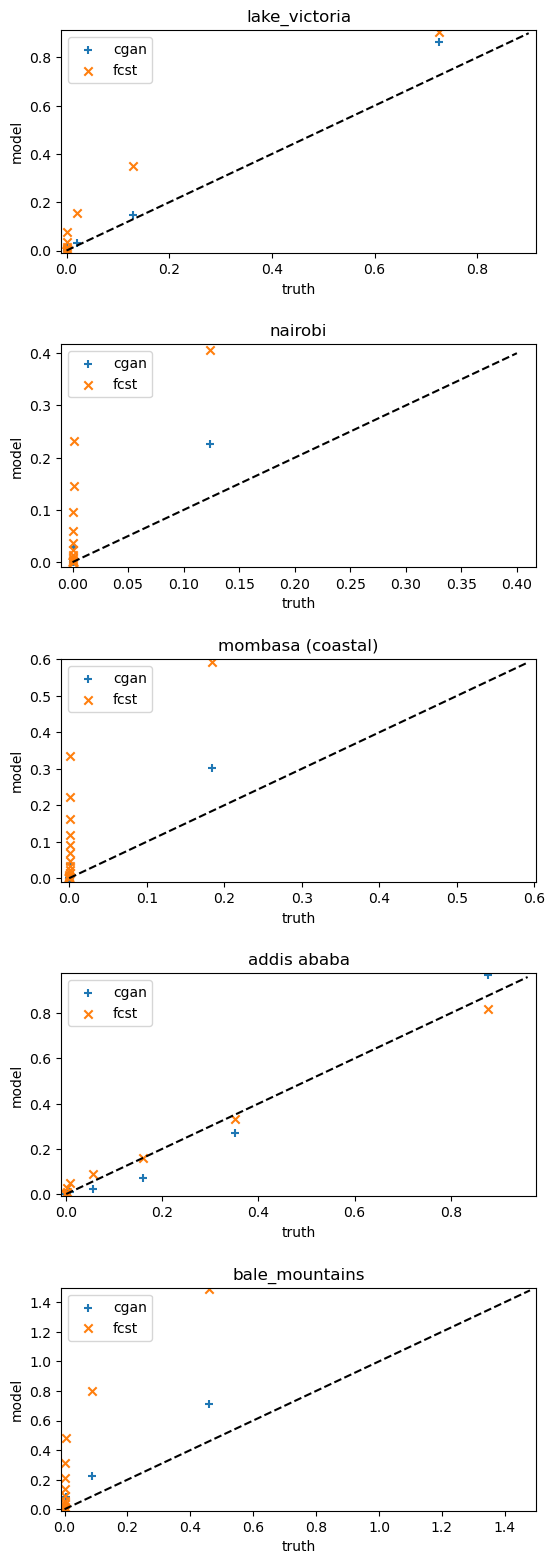

In [36]:
# Quantiles for different areas
quantile_boundaries = np.arange(0, 1, 1/20)

fig, ax = plt.subplots(max(2, len(special_areas)),1, figsize=(6, 16))

for n, (area, area_range) in enumerate(special_areas.items()):


    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    truth_quantiles = np.quantile(truth_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    sample_quantiles = np.quantile(samples_gen_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1], 0], quantile_boundaries)
    fcst_quantiles = np.quantile(fcst_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    
    max_val = max(max(truth_quantiles), max(sample_quantiles), max(fcst_quantiles))
    
    ax[n].scatter(truth_quantiles, sample_quantiles, marker='+', label='cgan')
    ax[n].scatter(truth_quantiles, fcst_quantiles, marker='x', label='fcst')
    ax[n].plot(np.arange(0,max_val, 0.01), np.arange(0,max_val, 0.01), 'k--')
    ax[n].set_xlabel('truth')
    ax[n].set_ylabel('model')
    ax[n].set_title(area)
    ax[n].set_xlim([-0.01, max_val + 0.01])
    ax[n].set_ylim([-0.01, max_val + 0.01])
    ax[n].legend()
    
fig.tight_layout(pad=2.0)
plt.savefig('cgan_metrics/quantiles_area.png')

## Grid metrics

In [40]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colorbar, colors, gridspec
from dsrnngan.plots import default_latitude_range, default_longitude_range


In [41]:
def plot_contourf(ax, data, title, value_range=None,lon_range=default_longitude_range, lat_range=default_latitude_range,
                  cmap='Reds'):
    
    if value_range:
        im = ax.contourf(lon_range, lat_range, data, transform=ccrs.PlateCarree(),
                            cmap=cmap, 
                            levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                            extend='both')
    else:
        im = ax.contourf(lon_range, lat_range, data, transform=ccrs.PlateCarree(),
                    cmap=cmap, 
                    extend='both')

    ax.coastlines(resolution='10m', color='black', linewidth=0.4)
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(title)
    
    return im

In [42]:
# RMSE
rmse_dict = {'single_sample_rmse': np.sqrt(np.mean(np.square(truth_array - samples_gen_array[:,:,:,0]), axis=0)),
            'ensmean_rmse' : np.sqrt(np.mean(np.square(truth_array - np.mean(samples_gen_array, axis=-1)), axis=0)),
            'fcst_rmse' : np.sqrt(np.mean(np.square(truth_array - fcst_array), axis=0))}

# Standard deviation of truth
truth_std = np.std(truth_array, axis=0)



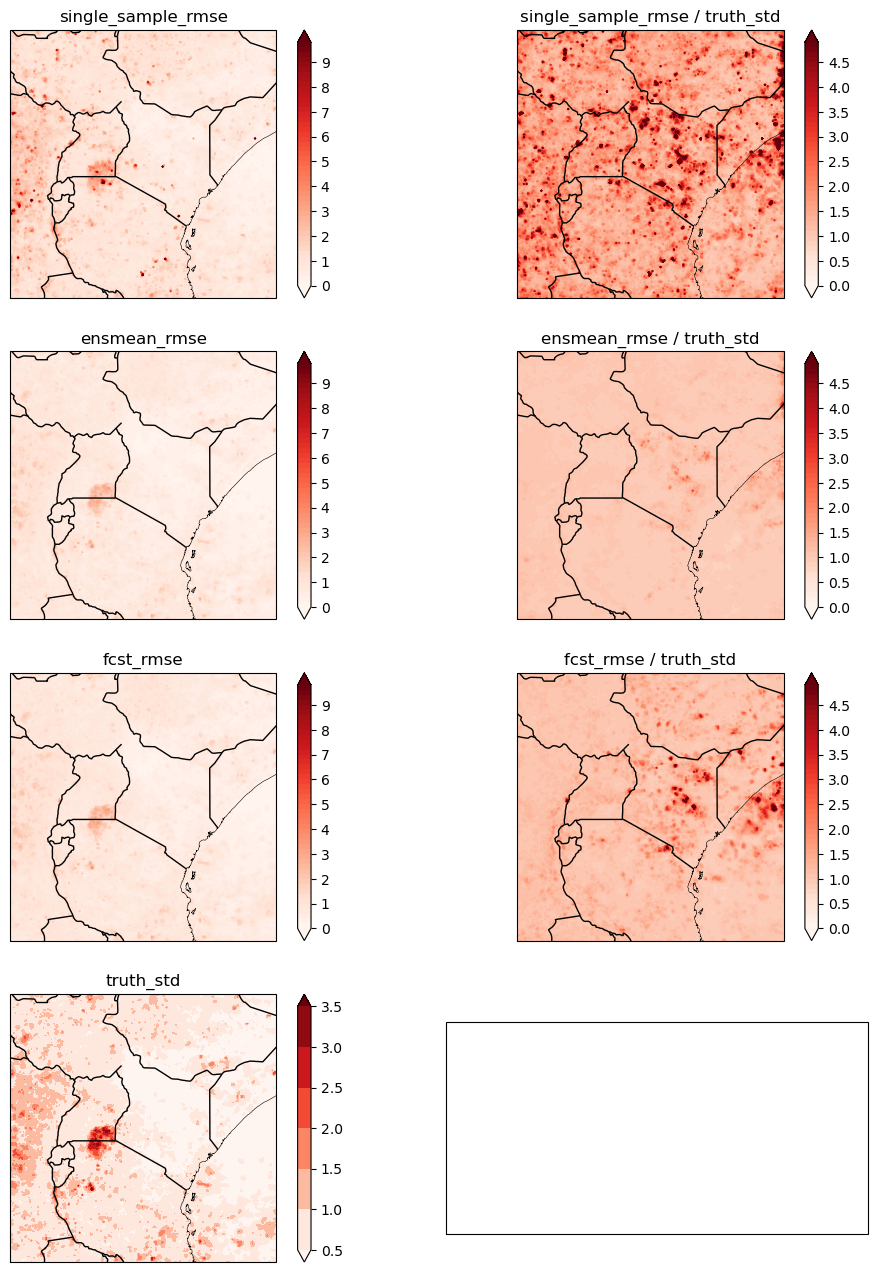

In [43]:
# RMSE
fig, ax = plt.subplots(len(rmse_dict.keys())+1,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))

max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

value_range_2 = list(np.arange(0, 5, 5 / 50))

for n, (k, v) in enumerate(rmse_dict.items()):
    
    im = plot_contourf(ax[n,0], v, title=k, value_range=value_range)
    plt.colorbar(im, ax=ax[n,0])
    ax[n,0].set_title(k)
    im2 = plot_contourf(ax[n,1], v / truth_std, title=k + ' / truth_std', value_range=value_range_2 )
    plt.colorbar(im2, ax=ax[n,1])

im = plot_contourf(ax[n+1,0], truth_std, title='truth_std')
plt.colorbar(im, ax=ax[n+1,0])

plt.savefig('cgan_metrics/rmse.png')


In [44]:
# bias
bias_dict = {'single_sample_bias': np.mean(truth_array - samples_gen_array[:,:,:,0], axis=0),
            'ensmean_bias' : np.mean(truth_array - np.mean(samples_gen_array, axis=-1), axis=0),
            'fcst_bias' : np.mean(truth_array - fcst_array, axis=0)}

# average of truth for comparison
truth_avg = np.mean(truth_array, axis=0)

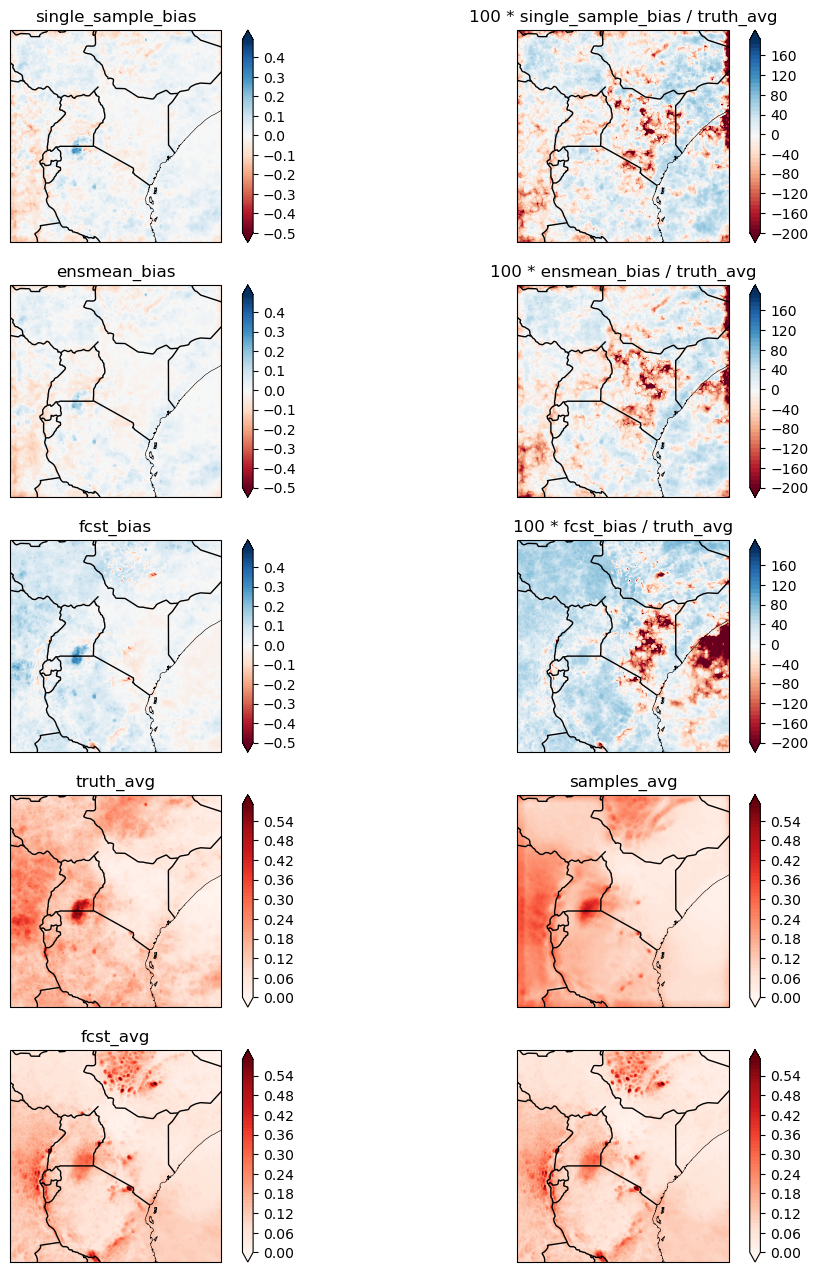

In [46]:

fig, ax = plt.subplots(len(bias_dict.keys())+2,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))

max_bias_val = max([v.max() for v in bias_dict.values()])

for n, (k,v) in enumerate(bias_dict.items()):


    value_range = list(np.arange(-0.5, 0.5, 0.01))

    im = plot_contourf(ax[n,0], v, title=k, cmap='RdBu', value_range=value_range)
    plt.colorbar(im, ax=ax[n,0])
    
    im = plot_contourf(ax[n,1], 100* v / truth_avg, title=f'100 * {k} / truth_avg', value_range=list(np.arange(-200, 200, 400 / 50)),
                       cmap='RdBu')
    plt.colorbar(im, ax=ax[n,1])
    
im = plot_contourf(ax[n+1,0], truth_avg, title='truth_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)))
plt.colorbar(im, ax=ax[n+1,0])

im = plot_contourf(ax[n+1,1], np.mean(np.mean(samples_gen_array, axis=-1), axis=0), title='samples_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)))
plt.colorbar(im, ax=ax[n+1,1])

im = plot_contourf(ax[n+2,0], np.mean(fcst_array, axis=0), title='fcst_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)))
plt.colorbar(im, ax=ax[n+2,0])

im = plot_contourf(ax[n+2,1], np.mean(fcst_array, axis=0), title='', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)))
plt.colorbar(im, ax=ax[n+2,1])

plt.savefig('cgan_metrics/bias.png')


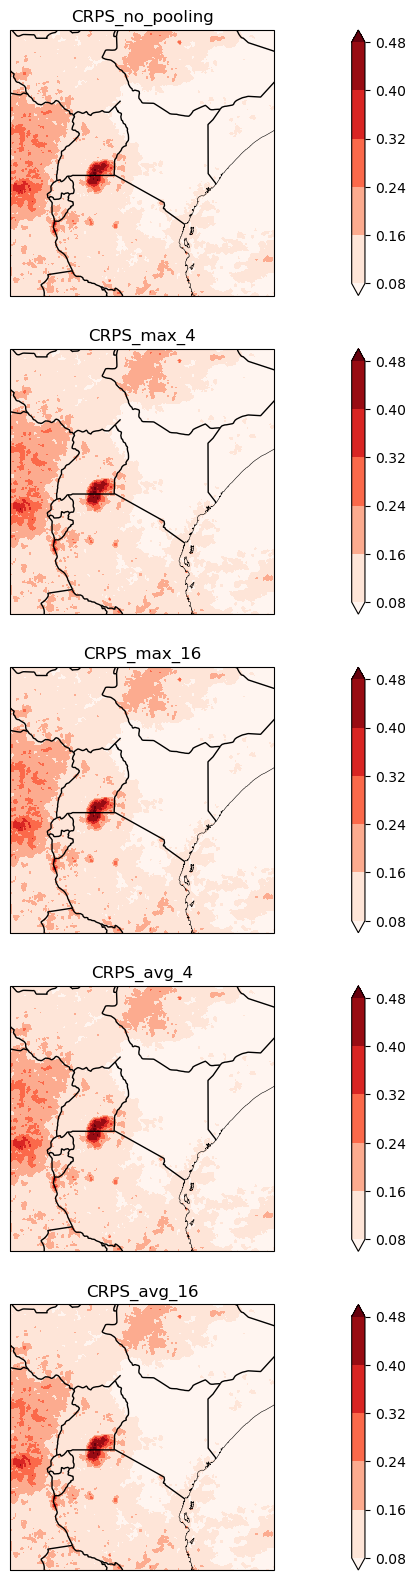

In [173]:
fig, ax = plt.subplots(len(crps_dict.keys()), 1, 
                       subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(20, 20))

for n, k in enumerate(crps_dict.keys()):

    max_level = 10
    value_range = list(np.arange(0, max_level, max_level / 50))

    im = ax[n].contourf(default_longitude_range, default_latitude_range, crps_dict[k], transform=ccrs.PlateCarree(),
                        cmap='Reds', 
                        # levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                        extend='both')

    ax[n].coastlines(resolution='10m', color='black', linewidth=0.4)
    ax[n].add_feature(cfeature.BORDERS)
    ax[n].set_title(k)
    plt.colorbar(im, ax=ax[n])
plt.savefig('cgan_metrics/crps.png')


## Scatter plots

In [128]:
import random

truth = arrays['truth']
samples_gen = arrays['samples_gen']

(num_images, height, width, ensemble_size) = samples_gen.shape

stacked_truth = np.repeat(truth[:, :, :, np.newaxis], ensemble_size, axis=3)

In [129]:
indexes = random.sample(range(len(samples_gen.flatten())), 10000)

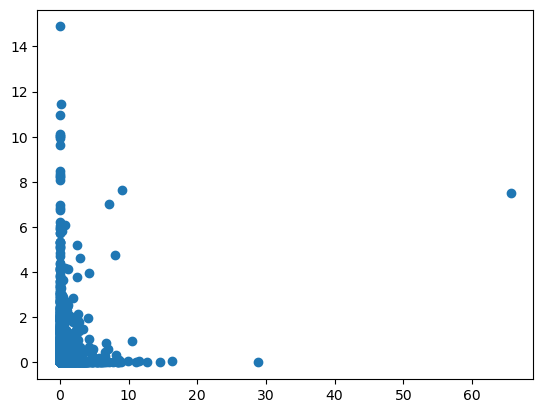

In [130]:
plt.scatter(samples_gen.flatten()[indexes], stacked_truth.flatten()[indexes])

# Fractional skill score

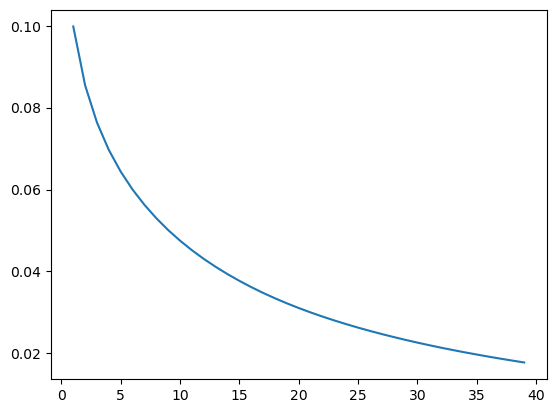

In [108]:
#evaluate percentage of rainy pixels based on threshold
daily_thresholds = range(1,40)
num_rainy_pixels = []
for thr in daily_thresholds:
    num_rainy_pixels.append((truth_array >= thr/24.0).astype(np.single).mean())
plt.plot(daily_thresholds, num_rainy_pixels)

In [119]:
from dsrnngan.scoring import fss
from tqdm import tqdm


window_sizes = list(range(1,11)) + [20, 40, 60, 80, 100] + [150, 200]
daily_thresholds = [1, 5, 20, 30, 50] # 1mm/day = drizzle, 50 mm/day = extreme

fss_cgan = []
fss_fcst = []
fss_ensmean = []

for thr in daily_thresholds:

    tmp_fss_cgan = []
    tmp_fss_fcst = []
    tmp_fss_ensmean = []

    for w in tqdm(window_sizes):
        
        tmp_fss_cgan.append(fss(truth_array, samples_gen_array, w, thr/24.0, mode='constant'))
        tmp_fss_fcst.append(fss(truth_array, fcst_array, w, thr/24.0, mode='constant'))
        tmp_fss_ensmean.append(fss(truth, ensmean_array, w, thr/24.0, mode='constant'))
    
    fss_cgan.append(tmp_fss_cgan)
    fss_fcst.append(tmp_fss_fcst)
    fss_ensmean.append(tmp_fss_ensmean)

100%|██████████| 17/17 [00:40<00:00,  2.39s/it]


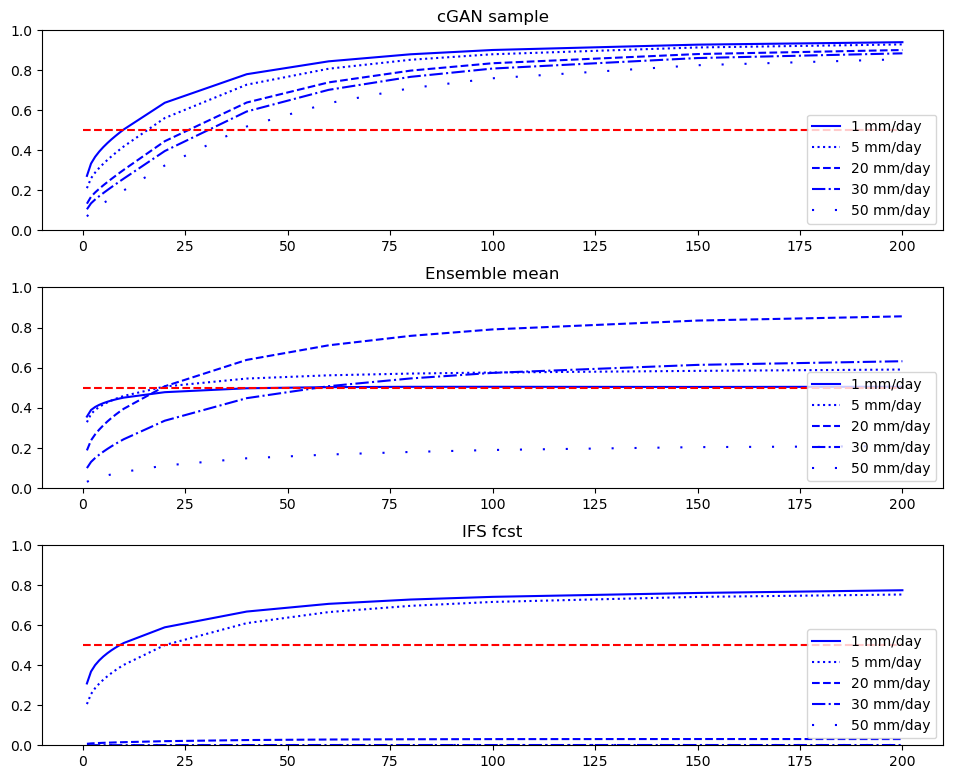

In [174]:
fig, axs = plt.subplots(3, 1, figsize = (10, 8))
fig.tight_layout(pad=2.0)
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1,10))]

for n, thr in enumerate(daily_thresholds):
    
    axs[0].plot(window_sizes, [item for item in fss_cgan[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])
    axs[1].plot(window_sizes, [item for item in fss_ensmean[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])
    axs[2].plot(window_sizes, [item for item in fss_fcst[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])

    axs[0].set_title('cGAN sample')
    axs[1].set_title('Ensemble mean')
    axs[2].set_title('IFS fcst')

for ax in axs:    
    ax.hlines(0.5, 0, max(window_sizes), linestyles='dashed', colors=['r'])
    ax.set_ylim(0,1)
    ax.set_xlabel('Neighbourhood size')
    ax.set_ylabel('FSS')
    ax.legend()
    
plt.savefig('cgan_metrics/fractional_skill_score.png')




In [177]:
!zip -r cgan_metrics.zip cgan_metrics

updating: cgan_metrics/ (stored 0%)
updating: cgan_metrics/fractional_skill_score.png (deflated 8%)
updating: cgan_metrics/bias.png (deflated 2%)
updating: cgan_metrics/quantiles_total.png (deflated 15%)
updating: cgan_metrics/rank_hist.png (deflated 16%)
updating: cgan_metrics/quantiles_area.png (deflated 21%)
updating: cgan_metrics/rmse.png (deflated 2%)
updating: cgan_metrics/rapds.png (deflated 6%)
updating: cgan_metrics/crps.png (deflated 10%)
  adding: cgan_metrics/cGAN_samples_IFS.png (deflated 6%)
